In [1]:
!pip install torchview

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import os
import certifi
import json
import torchvision
from torchview import draw_graph
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [3]:
os.environ['SSL_CERT_FILE'] = certifi.where()

data augmentation and normalization for training

In [4]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


data normalization for testing

In [5]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

load dataset

In [6]:
data_path = './data_cifar/'
cifar10_train = CIFAR10(data_path, train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10(data_path, train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:13<00:00, 12485991.92it/s]


Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar/
Files already downloaded and verified


split trainset to train an validation sets

In [7]:
train_size = int(0.9 * len(cifar10_train))
val_size = len(cifar10_train) - train_size
train_dataset, val_dataset = random_split(cifar10_train, [train_size, val_size])

define dataloaders

In [8]:
batch_size = 128
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

define model

In [9]:
class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()

        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()

        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))

        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)

        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)

        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)

        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)

        # Final Block input=(7x7)
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)

    def forward(self, x):

        # Block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)

        # Block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # Block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # Block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)

        # Block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # Block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # Block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # Block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)

        # Block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # Block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # Block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # Block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)

        # Block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # Block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # Block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # Block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_2(self.conv5_2_1(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)

        # FINAL BLOCK - classifier
        x = self.avgpool(op5)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc(x))
        x = self.out(x)

        return x

initialize the model, loss function, and optimizer

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_classes = 10
model = ResNet18(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

training function

In [11]:
def train(model, device, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(trainloader.dataset)
    train_accuracy = 100. * correct / total

    return train_loss, train_accuracy

evaluate function

In [12]:
def evaluate(model, device, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    average_loss = total_loss / len(dataloader.dataset)
    accuracy = 100. * correct / total

    return average_loss, accuracy

create directory for saving model

In [13]:
os.makedirs('./model_checkpoints', exist_ok=True)

save configurations

In [14]:
config = {
    "batch_size": 128,
    "learning_rate": 0.001,
    "epochs": 50,
    "transform_train": str(transform_train),
    "transform_test": str(transform_test),
    "device": str(device)
}
with open('./model_checkpoints/config.json', 'w') as f:
    json.dump(config, f, indent=4)

training phase

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50
patience = 7
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, device, trainloader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = evaluate(model, device, valloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_resnet18.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/50, Train Loss: 1.9455, Train Accuracy: 25.94%, Val Loss: 2.0293, Val Accuracy: 28.84%
Epoch 2/50, Train Loss: 1.7342, Train Accuracy: 35.85%, Val Loss: 2.0427, Val Accuracy: 32.88%
Epoch 3/50, Train Loss: 1.5738, Train Accuracy: 42.34%, Val Loss: 1.9030, Val Accuracy: 37.84%
Epoch 4/50, Train Loss: 1.4365, Train Accuracy: 47.96%, Val Loss: 1.4976, Val Accuracy: 48.42%
Epoch 5/50, Train Loss: 1.3428, Train Accuracy: 51.70%, Val Loss: 1.3132, Val Accuracy: 52.70%
Epoch 6/50, Train Loss: 1.2666, Train Accuracy: 54.57%, Val Loss: 1.2963, Val Accuracy: 54.08%
Epoch 7/50, Train Loss: 1.2112, Train Accuracy: 56.69%, Val Loss: 1.2966, Val Accuracy: 55.74%
Epoch 8/50, Train Loss: 1.1563, Train Accuracy: 58.86%, Val Loss: 1.2326, Val Accuracy: 55.90%
Epoch 9/50, Train Loss: 1.1077, Train Accuracy: 60.75%, Val Loss: 1.1798, Val Accuracy: 57.58%
Epoch 10/50, Train Loss: 1.0670, Train Accuracy: 62.25%, Val Loss: 1.0437, Val Accuracy: 63.12%
Epoch 11/50, Train Loss: 0.9582, Train Accuracy: 

test phase

In [16]:
model.load_state_dict(torch.load('best_resnet18.pth'))
test_loss, test_accuracy = evaluate(model, device, testloader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

<ipython-input-16-656ddad3f306>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18.pth'))


Test Loss: 0.5071, Test Accuracy: 82.44%


check network details

In [19]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,928
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
          Dropout-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,928
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

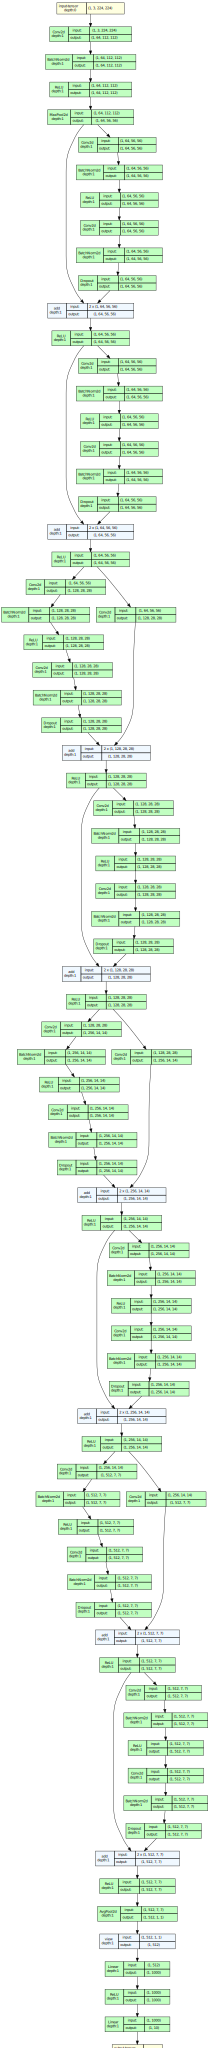

In [21]:
model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

plotting

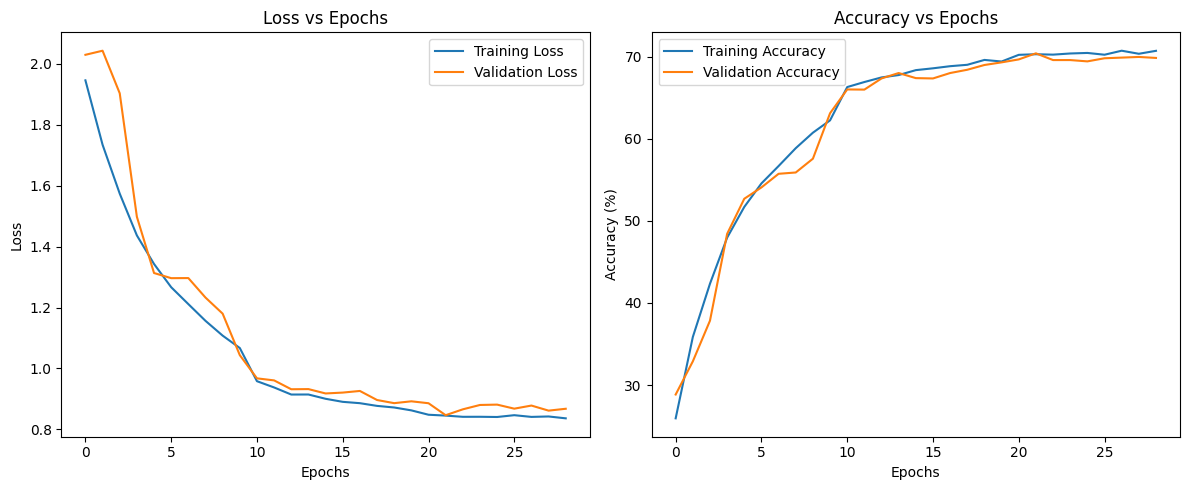

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()